# 5 - Independent Component Analysis

## Paola Suárez, Elisabeth Kress, Esra Zhini, Jiameng Wu

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio 
import time 
%matplotlib inline

### 5.1. Initialization

#### a. Load the sound files

In [2]:
sound1 = np.loadtxt('sounds/sound1.dat')
sound2 = np.loadtxt('sounds/sound2.dat')
original = np.array([sound1, sound2])

In [3]:
Audio(sound1, rate=8192)

In [4]:
Audio(sound2, rate=8192)

#### b. Create a random and invertible mixing matrix A

In [5]:
A = np.random.uniform(0, 1, (2, 2)) #scipy.stats.ortho_group.rvs
A_inv = np.linalg.inv(A)
mixed = np.dot(A, original)

In [6]:
Audio(mixed[0], rate=8192)

In [7]:
Audio(mixed[1], rate=8192)

#### c. Remove temporal structure

In [8]:
mixedT = mixed.T.copy()
np.random.shuffle(mixedT)
mixed_shuffle = mixedT.T

In [9]:
Audio(mixed_shuffle[0], rate=8192)

In [10]:
Audio(mixed_shuffle[1], rate=8192)

#### d. Calculate the correlations between the sources and the mixtures

In [11]:
corr = np.zeros((2,2))
for i in [0,1]:
    for j in [0,1]:
        matrix = np.cov(original[i], mixed_shuffle[j]) / (original[i].std() * mixed_shuffle[j].std())
        corr[i,j] = matrix[0,1]

In [12]:
print('Correlation matrix: \n', corr)
print('The data without temporal structure is no longer correlated, hence the noise in the sounds.')

Correlation matrix: 
 [[-0.00174132 -0.00123833]
 [ 0.00618957  0.00653092]]
The data without temporal structure is no longer correlated, hence the noise in the sounds.


#### e. Center the data

In [13]:
mixed_centered = np.subtract(mixed_shuffle.T, mixed_shuffle.mean(axis=1)).T

#### f. Initialize unmixing matrix W 

In [14]:
W0 = np.random.uniform(0, 1, (2, 2))

Initialization of unmixing matrix W, occurs within gradient_ascent functions in part two.

### 5.2. Optimization

In [15]:
# Helper function for the transformed data
def logistic(y):
    return 1/(1+np.exp(-y))

#### a. Regular gradient ascent

In [16]:
def reg_gradient_ascent(data, w0, eta0=.5):
    # regular gradient ascent
    ws = np.zeros((sound1.shape[0]+1, 2, 2))
    ws[0] = w0
    for t in np.arange(sound1.shape[0]):
        x = data[:, t]
        W = ws[t].copy()
        eta = eta0 / (t+1)
        W_inv = np.linalg.inv(W)
        update = W_inv.T + np.dot((1- 2*logistic(np.dot(W, x))).reshape(2,1), x.reshape(1,2))
        delta_W = eta*update
        W += delta_W
        ws[t+1] = W
    return ws

#### b. Natural gradient ascent

In [17]:
def nat_meng(data, w0, eta0=.5):
    # natural gradient ascent
    ws = np.zeros((sound1.shape[0]+1, 2, 2))
    ws[0] = w0
    for t in np.arange(sound1.shape[0]):
        x = data[:, t]
        W = ws[t].copy()
        eta = eta0 / (t+1)
        delta = np.identity(2)
        u = np.dot(W, x)
        update = np.dot(delta, W) + np.dot((1- 2*logistic(u)).reshape(2,1), np.dot(u.reshape(1,2), W))
        delta_W = eta * update
        W += delta_W
        ws[t+1] = W
    return ws

In [18]:
start1 = time.time()
Ws_n = nat_meng(mixed_centered, W0)
end1 = time.time()
W_n = Ws_n[-1]
unmixed_n = np.dot(W_n, mixed)

start2 = time.time()
Ws = reg_gradient_ascent(mixed_centered, W0)
end2 = time.time()
W = Ws[-1]
unmixed = np.dot(W, mixed)

print('regular: ', end2-start2)
print('natural: ', end1-start1)

regular:  0.9178030490875244
natural:  1.0528597831726074


In [19]:
Audio(unmixed[0], rate=8192)

In [20]:
Audio(unmixed[1], rate=8192)

In [21]:
Audio(unmixed_n[0], rate=8192)

In [22]:
Audio(unmixed_n[1], rate=8192)

### 5.3. Results

#### a. Play the sounds

The sounds have been played at each stage.

#### a. bis Plot the sounds

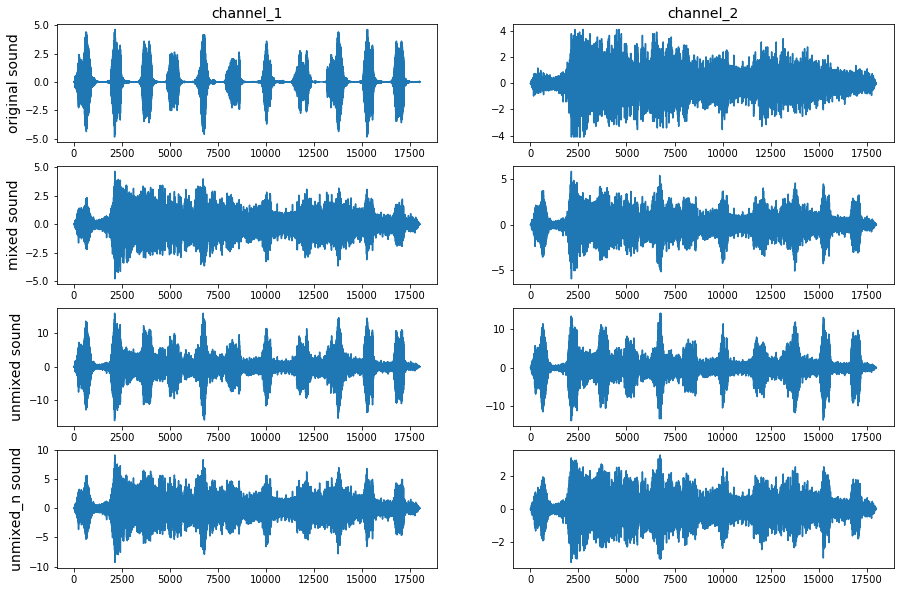

In [23]:
fig, axes = plt.subplots(4, 2, figsize=(15, 10))
sounds = [original, mixed, unmixed, unmixed_n]
labels1 = ['channel_1', 'channel_2']
labels2 = ["original", "mixed", "unmixed", "unmixed_n"]
for i in range(4):
    for j in [0, 1]:
        axes[0,j].set_title("%s" %labels1[j], size=14)
        axes[i,j].plot(sounds[i][j])
        axes[i,0].set_ylabel("%s sound" %labels2[i], size=14)
plt.show()

#### b. Correlations between sources and estimates

In [24]:
corr2 = np.zeros((2,2))
corr3 = np.zeros((2,2))
for i in [0,1]:
    for j in [0,1]:
        matrix2 = np.cov(original[i], unmixed[j]) / (original[i].std() * unmixed[j].std())
        matrix3 = np.cov(original[i], unmixed_n[j]) / (original[i].std() * unmixed_n[j].std())
        corr2[i,j] = matrix2[0,1]
        corr3[i,j] = matrix3[0,1]
        
print('Correlation between the true sources and the estimations using ...')
print('regular gradient ascent: \n', corr2)
print('natural gradient ascent: \n', corr3)

Correlation between the true sources and the estimations using ...
regular gradient ascent: 
 [[ 0.90810271 -0.89598843]
 [ 0.4200244   0.44307284]]
natural gradient ascent: 
 [[ 0.63850803 -0.5551762 ]
 [ 0.77049151  0.83109916]]


The regular gradient has a higher correlation for the first source (birds), but the natural gradient has a higher correlation for the second one (halleluja). 

#### c. Convergence speed using Frobenious norm

In [25]:
deltas = np.diff(Ws, axis=0)
Idx = np.append(np.arange(0, deltas.shape[0], 1e3).astype(int), deltas.shape[0]-1)
deltas_s = deltas[Idx]
norms = np.linalg.norm(deltas_s, ord='fro', axis=(1,2)) ** 2

deltas_n = np.diff(Ws_n, axis=0)
deltas_s_n = deltas_n[Idx]
norms_n = np.linalg.norm(deltas_s_n, ord='fro', axis=(1,2)) ** 2

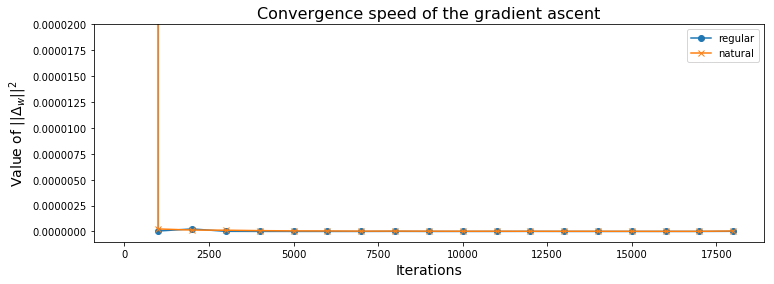

In [26]:
plt.figure(figsize=(12,4))
plt.title("Convergence speed of the gradient ascent", size=16)
plt.plot(Idx, norms, 'o-', label='regular')
plt.plot(Idx, norms_n, 'x-', label='natural')
plt.xlabel("Iterations", size=14)
plt.ylabel(r"Value of ${||\Delta_w\||}^2$", size=14)
plt.legend()
#plt.xlim(xmin=1000)
plt.ylim(-0.000001, .00002)
plt.show()

**Whiten data**

In [27]:
cov1 = np.cov(mixed_centered)
l, w = np.linalg.eig(cov1)
mixed_white = np.dot(np.diag(l**(-1/2)), np.dot(w.T, mixed_centered))

In [28]:
start1 = time.time()
Ws_n_w = nat_meng(mixed_white, W0)
end1 = time.time()
W_n_w = Ws_n_w[-1]
unmixed_n_w = np.dot(W_n_w, mixed)

start2 = time.time()
Ws_w = reg_gradient_ascent(mixed_white, W0)
end2 = time.time()
W_w = Ws_w[-1]
unmixed_w = np.dot(W_w, mixed)

print('regular: ', end2-start2)
print('natural: ', end1-start1)

regular:  1.1045198440551758
natural:  0.7858879566192627


In [29]:
deltas2 = np.diff(Ws_w, axis=0)
deltas_s2 = deltas2[Idx]
norms2 = np.linalg.norm(deltas_s2, ord='fro', axis=(1,2)) ** 2

deltas_n3 = np.diff(Ws_n_w, axis=0)
deltas_s_n3 = deltas_n3[Idx]
norms_n3 = np.linalg.norm(deltas_s_n3, ord='fro', axis=(1,2)) ** 2

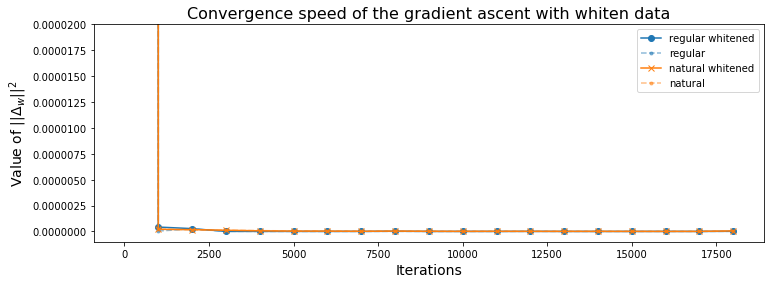

In [30]:
plt.figure(figsize=(12,4))
plt.title("Convergence speed of the gradient ascent with whiten data", size=16)
plt.plot(Idx, norms2, 'o-', c='C0', label='regular whitened')
plt.plot(Idx, norms, ".--", c='C0', alpha=0.5, label='regular')
plt.plot(Idx, norms_n3, 'x-', c='C1', label='natural whitened')
plt.plot(Idx, norms_n, ".--", c='C1', alpha=0.5, label='natural')
plt.xlabel("Iterations", size=14)
plt.ylabel(r"Value of ${||\Delta_w\||}^2$", size=14)
plt.legend()
#plt.xlim(xmin=1000)
plt.ylim(-0.000001, .00002)
plt.show()

In the natural gradient ascent method, the update value converges faster using the whiten data.

Whereas there is not a notorious change for the regular gradient ascent method.

**Describe the differences between the two variants of learning algorithm**

#### d. Density functions

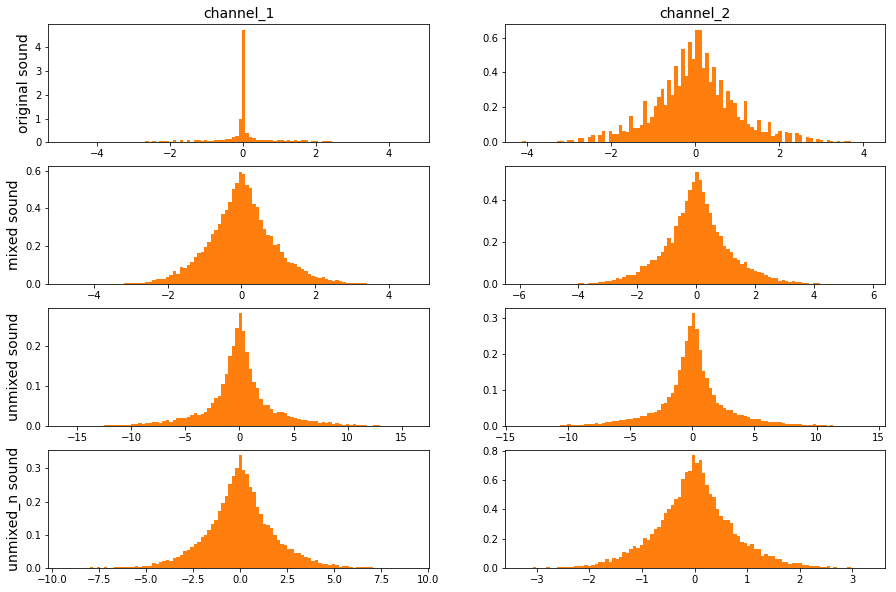

In [31]:
fig, axes = plt.subplots(4, 2, figsize=(15, 10))
sounds = [original, mixed, unmixed, unmixed_n]
labels1 = ['channel_1', 'channel_2']
labels2 = ["original", "mixed", "unmixed", "unmixed_n"]
cm = plt.cm.get_cmap('summer')
for i in range(4):
    for j in [0, 1]:
        axes[0,j].set_title("%s" %labels1[j], size=14)
        axes[i,j].hist(sounds[i][j], bins=100, color="C1", normed=True)
        axes[i,0].set_ylabel("%s sound" %labels2[i], size=14)
plt.show()

**Interpret your results**